# Binding binary classifiers from pairwise datasets

We begin to explore the impact of negative examples on the training of binary binding classifiers by evaluating the classifiers' performances when using negative training examples from a single antigen, i.e. distinguish antigen_1 from antigen_2.

In [31]:
from pathlib import Path
from itertools import combinations
import re
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def antigens_from_dir_name(dir_name: str) -> tuple:
    m = re.search(r"fit_pairwise_dataset_(.*)_(.*)_instruction", dir_name)
    if m:
        return m.groups()
    else:
        return None


BASE_PATH = Path("immuneML/pairwise_analysis_1_out")
pairwise_res = list(Path(BASE_PATH).glob("fit_pairwise_dataset_*_instruction"))

dfs = []
for res in pairwise_res:
    df_i = pd.read_csv(res / "binder_all_assessment_performances.csv")
    assert df_i.shape[0] == 1
    ag1, ag2 = antigens_from_dir_name(res.name)
    df_i["Ag1"] = ag1
    df_i["Ag2"] = ag2
    dfs.append(df_i)

df = pd.concat(dfs, axis=0)
assert df.shape[0] == 45
df.head(2)


,hp_setting,split,optimal,accuracy,f1_weighted,log_loss,confusion_matrix,recall,f1_micro,f1_macro,balanced_accuracy,precision,auc,Ag1,Ag2
0,kmerfreq_encoding_randomforest_default_model,1,False,0.835687,0.835678,0.390871,[[17699 3287]\n [ 3612 17389]],0.828008,0.835687,0.835678,0.835690,0.841023,0.906709,1H0D,3VRL
0,kmerfreq_encoding_randomforest_default_model,1,False,0.741906,0.741905,0.553001,[[15557 5510]\n [ 5324 15586]],0.745385,0.741906,0.741906,0.741919,0.738813,0.811371,1ADQ,3VRL


The dataset is balanced, hence `accuracy` is a good performance metric. Distribution of `accuracy` over the 45 pairwise datasets (10 choose 2 antigen pairs = 90/2) has a range of 69-88% with 2 local maxima around 77% and 83%, with an average of 79% and sd of 4.6%.

In [4]:
df["accuracy"].describe()

count    45.000000
mean      0.788951
std       0.046171
min       0.694294
25%       0.760558
50%       0.777092
75%       0.826946
max       0.880162
Name: accuracy, dtype: float64

<AxesSubplot:ylabel='Frequency'>

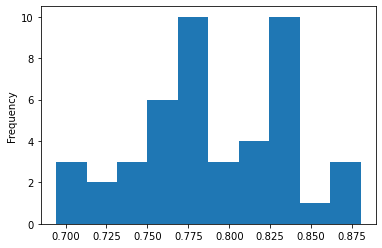

In [5]:
df["accuracy"].plot.hist()

In what follows, we check whether there are associations in terms of the ability of the binary classifier to distinguish an antigen from other. First, we generate the accuracy matrix, which describes the attained accuracy in distinguishing between a pair of antigens, e.g. row "1FBI" and column "1ADQ" describes the accuracy in distinguishing between 1FBI and 1ADQ.

In [6]:
antigens = sorted(set(df["Ag1"]).union(set(df["Ag2"])))
df_m = pd.DataFrame(np.zeros((10, 10)), columns = antigens, index = antigens)

for ag1, ag2 in combinations(antigens, 2):
    acc = df.loc[
        (df["Ag1"] == ag1) 
        & (df["Ag2"] == ag2)
        ]["accuracy"].values[0]
    df_m.loc[ag1, ag2] = acc
    df_m.loc[ag2, ag1] = acc

df_m

,1ADQ,1FBI,1H0D,1NSN,1OB1,1WEJ,2YPV,3RAJ,3VRL,5E94
1ADQ,0.000000,0.757824,0.863248,0.829057,0.775361,0.827875,0.836264,0.754203,0.741906,0.826946
1FBI,0.757824,0.000000,0.825061,0.774295,0.765722,0.815070,0.760558,0.704445,0.799657,0.792182
1H0D,0.863248,0.825061,0.000000,0.880162,0.770894,0.836132,0.759420,0.768126,0.835687,0.769163
1NSN,0.829057,0.774295,0.880162,0.000000,0.799871,0.867561,0.773033,0.821447,0.854948,0.827279
1OB1,0.775361,0.765722,0.770894,0.799871,0.000000,0.773056,0.827866,0.732809,0.786660,0.724984
1WEJ,0.827875,0.815070,0.836132,0.867561,0.773056,0.000000,0.825894,0.699886,0.772882,0.821805
2YPV,0.836264,0.760558,0.759420,0.773033,0.827866,0.825894,0.000000,0.717835,0.738721,0.777092
3RAJ,0.754203,0.704445,0.768126,0.821447,0.732809,0.699886,0.717835,0.000000,0.694294,0.771252
3VRL,0.741906,0.799657,0.835687,0.854948,0.786660,0.772882,0.738721,0.694294,0.000000,0.824370
5E94,0.826946,0.792182,0.769163,0.827279,0.724984,0.821805,0.777092,0.771252,0.824370,0.000000


Next, we check the accuracy distribution for each antigen. We observe below that:

1. The maximal accuracy varies among the antigens, e.g. max for `1H0D` 87.7% vs max for `3RAJ` 82% (delta ~5%).
2. The minimal accuracy varies among the antigens, e.g. min for `1NSN` 77.6% vs min for `3VRL` of 69.5% (delta ~8%). 

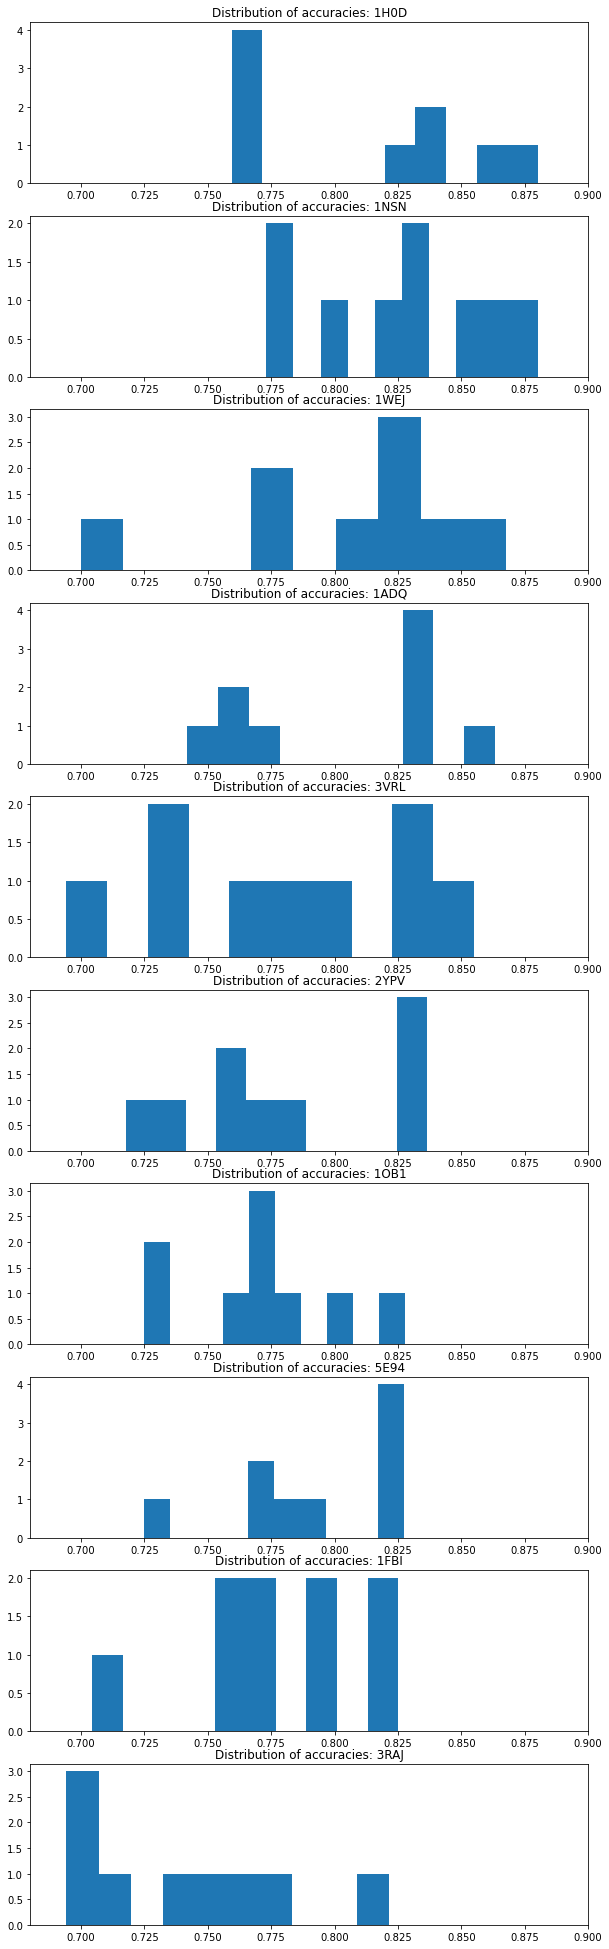

In [7]:
fig, axs = plt.subplots(
    nrows=10, 
    sharex=False,
    figsize=(10, 35)
)

for i, ag in enumerate(sorted(antigens, key=lambda ag: -df_m.apply(max).to_dict().get(ag))):
    acc_s = df_m[ag]
    acc_s = acc_s[acc_s != 0.0]
    axs[i].hist(acc_s)
    axs[i].set_xlim((0.68, 0.9))
    axs[i].set_title(f"Distribution of accuracies: {ag}")

Let's compare the accuracies for distinguishing binding of 2 targets with antibody heavy chain structural similarity.

In [26]:
df_str = pd.read_csv("data/pdb/DATA_SLACK_1_Ab_rmsd_h12.tsv", sep='\t', index_col=0)
df_str.columns = df_str.columns.map(lambda s: s.upper())
df_str.index = df_str.index.map(lambda s: s.upper())
print("Heavy chain RMSDs:")
df_str

Heavy chain RMSDs:


,1ADQ,1FBI,1H0D,1NSN,1OB1,1WEJ,2YPV,3RAJ,3VRL,5E94
1ADQ,0.000000,2.825719,2.836272,10.516155,4.058735,6.901963,4.990480,5.630270,1.828644,2.735488
1FBI,2.825719,0.000000,2.472031,9.761009,2.883387,5.980340,3.856136,4.784676,1.923540,2.913895
1H0D,2.836272,2.472031,0.000000,9.226916,2.183493,5.150612,3.117919,3.897954,1.876613,3.214049
1NSN,10.516155,9.761009,9.226916,0.000000,8.142435,5.870526,7.495962,7.735213,9.998324,10.570730
1OB1,4.058735,2.883387,2.183493,8.142435,0.000000,3.934990,1.977593,3.310788,3.051037,4.317094
1WEJ,6.901963,5.980340,5.150612,5.870526,3.934990,0.000000,3.141066,4.221000,6.100825,7.028906
2YPV,4.990480,3.856136,3.117919,7.495962,1.977593,3.141066,0.000000,3.106918,4.068642,5.237804
3RAJ,5.630270,4.784676,3.897954,7.735213,3.310788,4.221000,3.106918,0.000000,4.871726,5.909105
3VRL,1.828644,1.923540,1.876613,9.998324,3.051037,6.100825,4.068642,4.871726,0.000000,2.622618
5E94,2.735488,2.913895,3.214049,10.570730,4.317094,7.028906,5.237804,5.909105,2.622618,0.000000


In [29]:
acc_vals = df_m.values[np.triu_indices_from(df_m, k=1)]
rmsd_vals = df_str.values[np.triu_indices_from(df_str, k=1)]

print("Correlations between accuracy and rmsd:")
(
    stats.pearsonr(acc_vals, rmsd_vals),
    stats.spearmanr(acc_vals, rmsd_vals)
)

Correlations between accuracy and rmsd:


((0.29188387115690495, 0.051712907273288984),
 SpearmanrResult(correlation=0.19565217391304346, pvalue=0.19773498219047492))

<AxesSubplot:>

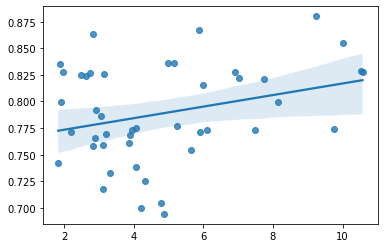

In [33]:
sns.regplot(x=rmsd_vals, y=acc_vals)

# Follow-up

Similar basic analysis on `1_vs_all` datasets, i.e. datasets in which, for each antigen, we include all the 9 other antigens in the negative dataset. The objective is to check if antigens for which the binary classifier performs well in the pairwise datasets attain higher performance in `1_vs_all` datasets.